Requires py3 and new saga

# Imports/Setup 

In [1]:
import os
import sys
import urllib
from collections import defaultdict

import numpy as np

from astropy import units as u
from astropy import table
from astropy.coordinates import SkyCoord, EarthLocation, get_sun
from astropy.time import Time

import astroplan, astroplan.plots

import tqdm
from urllib.request import urlopen, HTTPError

from importlib import reload

In [2]:
%matplotlib inline
from matplotlib import style, pyplot as plt

The below cells build the saga repo and sets the path to look for it

In [3]:
working_dir = os.path.abspath('..')

In [4]:
%cd ../../saga
sagadir = !pwd
sagadir = sagadir[0]
!python setup.py build
%cd $working_dir

/Users/erik/projects/saga/saga
running build
running build_py
/Users/erik/projects/saga/erik


In [5]:
sagalibdir = os.path.join(sagadir, 'build/lib')
print('Adding', sagalibdir, 'to the python path')
sys.path.insert(0, sagalibdir)

import SAGA as saga
saga.__version__

Adding /Users/erik/projects/saga/saga/build/lib to the python path


'0.10.10'

In [6]:
from SAGA.database import external

In [7]:
aat = astroplan.Observer.at_site('Anglo-Australian Observatory')

run_start = aat.midnight(Time('2018-10-3'), 'next')
run_end = aat.midnight(Time('2018-10-6'), 'next')
run_mid = aat.midnight(Time((run_start.jd + run_end.jd)/2, format='jd'))

# Load the right hosts 

In [9]:
db = saga.Database('SAGADropbox')
saga_host_cat = saga.HostCatalog(db)
saga_obj_cat = saga.ObjectCatalog(db)


host_id_label = 'ID_STR'
targetstr = 'aat_2018b'
targethosts = saga_host_cat.load(targetstr)
targethosts[host_id_label] = saga_host_cat.resolve_id(targetstr, 'string')
targethosts

SAGA_name,NSAID,RA,Dec,PGC,NSA1ID,NGC,UGC,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,RA_sub,Dec_sub,othername,vhelio_sub,vhelio_err,distance_sub,dist_2MASS_NSA,u,u_err,A_u,M_u,g,g_err,A_g,M_g,r_sub,r_err,A_r,M_r,i_sub,i_err,A_i,M_i,z_sub,z_err,A_z,M_z,J,J_err,A_J,M_J,H,H_err,A_H,M_H,K_sub,K_err_sub,A_K,M_K,stellar_mass,sersic_n,MK_compiled,des_dr1,decals_dr5,decals_dr6,decals_dr7,coord,ID_STR
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",
str11,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,object,str9
--,-1,8.0088,-64.2534,1952,-1,-1,-1,2704.0,39.2829,--,--,--,11.46,9.01,0.022,48,-23.961,--,-52.7437,20.145,12.03,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-23.961,0.9885177612,0.0,0.0,0.0,"8.0088,-64.2534",pgc1952
--,-1,8.56455,-27.8037,2052,-1,150,-1,1583.0,22.9306,--,--,--,10.29,8.506,0.02,48,-23.2961,--,-86.13,7.30434,12.136,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-23.2961,1.0,0.0,0.0,0.0,"8.56455,-27.8037",pgc2052
--,-1,38.3929,-39.045,9747,-1,986,-1,2004.0,29.0608,--,--,--,9.84,7.772,0.018,48,-24.5445,--,-65.6357,11.1456,--,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-24.5445,1.0,0.0,0.0,0.0,"38.3929,-39.045",pgc9747
--,-1,43.6395,-18.635,10965,-1,1145,-1,1968.0,28.5361,--,--,--,11.42,9.265,0.029,48,-23.012,--,-60.4866,10.445,--,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-23.012,1.0,1.0,0.0,1.0,"43.6395,-18.635",pgc10965
--,133355,50.5273,-15.3999,12626,620854,1309,-1,2136.0,31.352,11.9008,11.6953,11.5496,10.61,9.088,0.03,16416,-23.3933,-20.5805,-53.1568,12.8135,--,0.0,50.5273,-15.3999,g0322066-152400,2136.0,-1,31.352,0.516322,12.9503,1019.31,0.169276,-19.7323,11.7291,9.55517,0.131898,-20.8896,11.2191,27.2966,0.0912467,-21.3626,10.9675,4.64114,0.0678061,-21.5848,10.7841,8.34122,0.0504353,-21.7524,10.056,0.017,0.0283124,-22.4525,9.379,0.02,0.0179299,-23.122,9.102,0.029,0.0120597,-23.3779,13700000000,1.49357,-23.3933,1.0,1.0,0.0,1.0,"50.5273,-15.3999",nsa133355
--,-1,304.322,-52.7968,64427,-1,6887,-1,2666.0,38.727,--,--,--,10.96,8.854,0.036,48,-24.0861,--,-34.0617,15.8025,--,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-24.0861,1.0,0.0,0.0,0.0,"304.322,-52.7968",pgc64427
--,-1,323.147,-44.0676,66934,-1,7079,-1,2670.0,38.7855,--,--,--,10.48,8.566,0.018,48,-24.3773,--,-46.9401,17.7242,12.234,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-24.3773,1.0,0.0,0.0,0.0,"323.147,-44.0676",pgc66934
--,-1,325.054,-42.5394,67146,-1,7097,-1,2404.0,34.8975,--,--,--,10.56,8.676,0.016,48,-24.038,--,-48.48,14.3966,11.641,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-24.038,1.0,0.0,0.0,0.0,"325.054,-42.5394",pgc67146


# Airmass plot

In [10]:
host_targets = []
for h in targethosts:
    name = 'NSA{}'.format(h['NSAID'])
    if h['SAGA_name'] != '':
        name = h['SAGA_name']
    elif h['NSAID']==-1:
        name = 'PGC{}'.format(h['PGC'])
    host_targets.append(astroplan.FixedTarget(h['coord'], name))

Text(0.5,0,'LST [hr]')

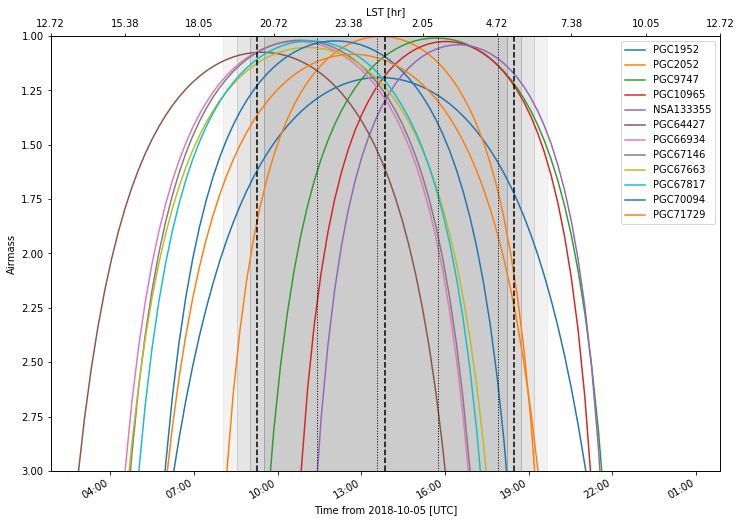

In [24]:
plt.figure(figsize=(12, 8))

astroplan.plots.plot_airmass(host_targets, aat, run_mid, brightness_shading=True)
plt.legend(loc=0)

#vertical lines every ~2 hr starting at -15 min 18deg
start_obs = aat.twilight_evening_astronomical(run_mid)-15*u.min
end_obs = aat.twilight_morning_astronomical(run_mid)+15*u.min
for t in (start_obs, run_mid, end_obs):
    plt.axvline(t.plot_date, ls='--', c='k')

dt = 130*u.min
t = start_obs + dt
while t < end_obs:
    plt.axvline(t.plot_date, c='k', ls=':', lw=1)
    t += dt
    
# make the LST axis
xl, xu = plt.xlim()
dt = (Time(xu, format='plot_date') - Time(xl, format='plot_date')).to(u.hour)
lsts = (aat.local_sidereal_time(Time(xl, format='plot_date')).hour + np.linspace(0, dt.value, 10))*dt.unit
plt.twiny()
plt.xticks(lsts.value, ['{.value:.2f}'.format(l) for l in (lsts % (24*u.hour)).to(u.hour)])
plt.xlim(lsts.value[0], lsts.value[-1])
plt.xlabel('LST [hr]')

# Catalog generation

In [47]:
sdsshosts = saga_host_cat.load('has_nsa')
sdsshosts[host_id_label] = saga_host_cat.resolve_id('has_nsa', 'string')
hosts_todl = targethosts[np.in1d(targethosts[host_id_label], sdsshosts[host_id_label])]


failed = external.download_catalogs_for_hosts(hosts_todl, external.SdssQuery, 
                                              db.sdss_file_path_pattern, 
                                              overwrite=False, 
                                              host_id_label=host_id_label)
print('# failed =', np.sum(failed), '# good = ', np.sum(~failed))

[09/28 17:40:35] Getting catalog for host nsa133355 ...
[09/28 17:40:37] casjob (SAGAjghn) submitted...
[09/28 18:28:55] casjob (SAGAjghn) finished, downloading data...
# failed = 0 # good =  1


In [12]:
deshosts = saga_host_cat.load('has_des')
deshosts[host_id_label] = saga_host_cat.resolve_id('has_des', 'string')
hosts_todl = targethosts[np.in1d(targethosts[host_id_label], deshosts[host_id_label])]

failed = external.download_catalogs_for_hosts(hosts_todl, external.DesQuery, 
                                              db.des_file_path_pattern, 
                                              overwrite=True, 
                                              host_id_label=host_id_label)
print('# failed =', np.sum(failed), '# good = ', np.sum(~failed))

[10/04 22:11:32] Getting catalog for host pgc1952 ...
[10/04 22:12:35] Getting catalog for host pgc2052 ...
[10/04 22:13:39] Getting catalog for host pgc9747 ...
[10/04 22:14:33] Getting catalog for host pgc10965 ...
[10/04 22:16:16] Getting catalog for host nsa133355 ...
[10/04 22:17:40] Getting catalog for host pgc64427 ...
[10/04 22:19:16] Getting catalog for host pgc66934 ...
[10/04 22:20:58] Getting catalog for host pgc67146 ...
[10/04 22:22:48] Getting catalog for host pgc67663 ...
[10/04 22:23:58] Getting catalog for host pgc67817 ...
[10/04 22:25:30] Getting catalog for host pgc70094 ...
[10/04 22:27:18] Getting catalog for host pgc71729 ...
# failed = 0 # good =  12


In [107]:
intempl = 'http://www.slac.stanford.edu/~yymao/saga/base-catalogs-non-sdss/{}_decals_dr7.fits.gz'
outtempl = 'external_catalogs/decals/{}_decals.fits.gz'
for name in tqdm.tqdm_notebook(targethosts[host_id_label]):
    inurl = intempl.format(name)
    outfn = outtempl.format(name)
    try:
        CHUNK = 1024
        with urlopen(inurl) as r:
            length = int(r.headers['Content-Length'])
            t = tqdm.tqdm_notebook(total=length)
            res = '1'
            with open(outfn, 'wb') as f:
                while len(res)>0:
                    res = r.read(CHUNK)
                    f.write(res)
                    t.update(len(res))
    except HTTPError:
        print('skipping', name)

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

skipping pgc1952
skipping pgc2052
skipping pgc9747


HBox(children=(IntProgress(value=0, max=90484603), HTML(value='')))

HBox(children=(IntProgress(value=0, max=93050188), HTML(value='')))

skipping pgc64427
skipping pgc66934
skipping pgc67146
skipping pgc67663
skipping pgc67817
skipping pgc70094
skipping pgc71729



# Now build base catalogs 

In [21]:
saga_obj_cat.build_and_write_to_database(targethosts[host_id_label], overwrite=True)

[10/04 23:01:21] [WARNING] Not found: SDSS catalog for pgc1952.
[10/04 23:01:22] [WARNING] Not found: DECALS catalog for pgc1952.
[10/04 23:01:22] Use DES to build base catalog v2 for pgc1952 (1/12)


[10/04 23:01:41] Write base catalog to ./base_catalogs/base_v2_pgc1952.fits.gz
[10/04 23:01:56] [WARNING] Not found: SDSS catalog for pgc2052.
[10/04 23:01:57] [WARNING] Not found: DECALS catalog for pgc2052.
[10/04 23:01:57] Use DES to build base catalog v2 for pgc2052 (2/12)


[10/04 23:02:51] Write base catalog to ./base_catalogs/base_v2_pgc2052.fits.gz
[10/04 23:03:04] [WARNING] Not found: SDSS catalog for pgc9747.
[10/04 23:03:05] [WARNING] Not found: DECALS catalog for pgc9747.
[10/04 23:03:05] Use DES to build base catalog v2 for pgc9747 (3/12)


[10/04 23:03:24] Write base catalog to ./base_catalogs/base_v2_pgc9747.fits.gz
[10/04 23:03:38] [WARNING] Not found: SDSS catalog for pgc10965.
[10/04 23:03:43] Use DES, DECALS to build base catalog v2 for pgc10965 (4/12)


[10/04 23:05:16] Write base catalog to ./base_catalogs/base_v2_pgc10965.fits.gz
[10/04 23:06:19] Use SDSS, DES, DECALS to build base catalog v2 for nsa133355 (5/12)


/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


[10/04 23:07:58] Write base catalog to ./base_catalogs/base_v2_nsa133355.fits.gz
[10/04 23:09:02] [WARNING] Not found: SDSS catalog for pgc64427.
[10/04 23:09:03] [WARNING] Not found: DECALS catalog for pgc64427.
[10/04 23:09:03] Use DES to build base catalog v2 for pgc64427 (6/12)


[10/04 23:09:41] Write base catalog to ./base_catalogs/base_v2_pgc64427.fits.gz
[10/04 23:09:58] [WARNING] Not found: SDSS catalog for pgc66934.
[10/04 23:09:59] [WARNING] Not found: DECALS catalog for pgc66934.
[10/04 23:09:59] Use DES to build base catalog v2 for pgc66934 (7/12)


[10/04 23:10:28] Write base catalog to ./base_catalogs/base_v2_pgc66934.fits.gz
[10/04 23:10:46] [WARNING] Not found: SDSS catalog for pgc67146.
[10/04 23:10:47] [WARNING] Not found: DECALS catalog for pgc67146.
[10/04 23:10:47] Use DES to build base catalog v2 for pgc67146 (8/12)


[10/04 23:11:25] Write base catalog to ./base_catalogs/base_v2_pgc67146.fits.gz
[10/04 23:11:45] [WARNING] Not found: SDSS catalog for pgc67663.
[10/04 23:11:46] [WARNING] Not found: DECALS catalog for pgc67663.
[10/04 23:11:46] Use DES to build base catalog v2 for pgc67663 (9/12)


[10/04 23:12:10] Write base catalog to ./base_catalogs/base_v2_pgc67663.fits.gz
[10/04 23:12:23] [WARNING] Not found: SDSS catalog for pgc67817.
[10/04 23:12:23] [WARNING] Not found: DECALS catalog for pgc67817.
[10/04 23:12:23] Use DES to build base catalog v2 for pgc67817 (10/12)


[10/04 23:13:02] Write base catalog to ./base_catalogs/base_v2_pgc67817.fits.gz
[10/04 23:13:19] [WARNING] Not found: SDSS catalog for pgc70094.
[10/04 23:13:20] [WARNING] Not found: DECALS catalog for pgc70094.
[10/04 23:13:20] Use DES to build base catalog v2 for pgc70094 (11/12)


[10/04 23:13:51] Write base catalog to ./base_catalogs/base_v2_pgc70094.fits.gz
[10/04 23:14:07] [WARNING] Not found: SDSS catalog for pgc71729.
[10/04 23:14:08] [WARNING] Not found: DECALS catalog for pgc71729.
[10/04 23:14:08] Use DES to build base catalog v2 for pgc71729 (12/12)


[10/04 23:14:31] Write base catalog to ./base_catalogs/base_v2_pgc71729.fits.gz


### Check base catalog sizes 

In [23]:
loaded = saga_obj_cat.load(targethosts[host_id_label])
for cat, host in zip(loaded, targethosts):
    print(host[host_id_label], len(cat))

pgc1952 221424
pgc2052 210624
pgc9747 209878
pgc10965 297290
nsa133355 306942
pgc64427 245767
pgc66934 256300
pgc67146 300349
pgc67663 194873
pgc67817 268839
pgc70094 262361
pgc71729 274485


pgc1952 221425
pgc2052 210625
pgc9747 209879
pgc10965 297290
nsa133355 306942
pgc64427 245768
pgc66934 256301
pgc67146 300350
pgc67663 194874
pgc67817 268840
pgc70094 262362
pgc71729 274486


In [149]:
# prior to regeneration night before
print("""
pgc1952 221425
pgc2052 210625
pgc9747 209879
pgc10965 297290
nsa133355 306941
pgc64427 245768
pgc66934 256301
pgc67146 300350
pgc67663 194874
pgc67817 268840
pgc70094 262362
pgc71729 274486
"""[1:-1])

pgc1952 221425
pgc2052 210625
pgc9747 209879
pgc10965 297290
nsa133355 306941
pgc64427 245768
pgc66934 256301
pgc67146 300350
pgc67663 194874
pgc67817 268840
pgc70094 262362
pgc71729 274486


# Gaia Catalog downloads (for astrometry fix to DES)

In [141]:
for nm in targethosts[host_id_label]:
    fn = 'external_catalogs/astrometric/{}_gaia.ecsv'.format(nm)
    !ls $fn

external_catalogs/astrometric/pgc1952_gaia.ecsv
external_catalogs/astrometric/pgc2052_gaia.ecsv
external_catalogs/astrometric/pgc9747_gaia.ecsv
external_catalogs/astrometric/pgc10965_gaia.ecsv
external_catalogs/astrometric/nsa133355_gaia.ecsv
external_catalogs/astrometric/pgc64427_gaia.ecsv
external_catalogs/astrometric/pgc66934_gaia.ecsv
external_catalogs/astrometric/pgc67146_gaia.ecsv
external_catalogs/astrometric/pgc67663_gaia.ecsv
external_catalogs/astrometric/pgc67817_gaia.ecsv
external_catalogs/astrometric/pgc70094_gaia.ecsv
external_catalogs/astrometric/pgc71729_gaia.ecsv


In [136]:
from astroquery.gaia import Gaia

from getpass import getpass

#Gaia.login(input('username:'), getpass('pw:'))

In [137]:
# this hides the warnings from parsing VOTables from Gaia
import warnings
from astropy.io.votable.exceptions import VOTableSpecWarning
warnings.simplefilter('ignore', VOTableSpecWarning)

In [138]:
gaiajobs = {}
for field in targethosts:
    fnm = field[host_id_label]
    fn = 'external_catalogs/astrometric/{}_gaia.ecsv'.format(fnm)
    if os.path.exists(fn):
        print('File', fn, 'exists, skipping.')
        continue
    else:
        print('Starting job for', fnm)
    gaiajob = Gaia.cone_search_async(field['coord'], radius=1*u.deg, background=True)
    gaiajobs[fnm] = gaiajob

Starting job for pgc1952
File external_catalogs/astrometric/pgc2052_gaia.ecsv exists, skipping.
Starting job for pgc9747
Starting job for pgc10965
Starting job for nsa133355
File external_catalogs/astrometric/pgc64427_gaia.ecsv exists, skipping.
File external_catalogs/astrometric/pgc66934_gaia.ecsv exists, skipping.
File external_catalogs/astrometric/pgc67146_gaia.ecsv exists, skipping.
File external_catalogs/astrometric/pgc67663_gaia.ecsv exists, skipping.
File external_catalogs/astrometric/pgc67817_gaia.ecsv exists, skipping.
File external_catalogs/astrometric/pgc70094_gaia.ecsv exists, skipping.
File external_catalogs/astrometric/pgc71729_gaia.ecsv exists, skipping.


In [139]:
#check phases
nqueued = 0
ncompleted = 0
nother = 0
for nm, job in gaiajobs.items():
    ph = job.get_phase(True)
    print(nm, job.get_jobid(), ph)
    if ph == 'QUEUED':
        nqueued += 1
    elif ph == 'COMPLETED':
        ncompleted += 1
    else:
        nother +=1
nall = nqueued + ncompleted + nother
print('q:{:%}, c:{:%}, o:{:%}'.format(nqueued/nall, ncompleted/nall, nother/nall))

pgc1952 1538259025987O COMPLETED
pgc9747 1538259026234O COMPLETED
pgc10965 1538259026483O COMPLETED
nsa133355 1538259026733O COMPLETED
q:0.000000%, c:100.000000%, o:0.000000%


In [140]:
saved = []

with tqdm.tqdm_notebook(total=len(gaiajobs)) as pbar:
    nq = np.inf
    while nq > 0 and len(saved)< len(gaiajobs):
        print('\r', end='')
        print('still have {} queued and {} saved of {} ... sleeping'.format(nq, len(saved), len(gaiajobs)), end='')
        if nq != np.inf:
            time.sleep(60)
        pbar.unpause()
        
        nq = 0
        for fnm, job in gaiajobs.items():
            ph = job.get_phase(True)
            if ph == 'COMPLETED' and fnm not in saved:
                print('\r', end='')
                print('Loading', fnm, end=' ... ')
                gaia_data = job.get_data()
                fn = 'external_catalogs/astrometric/{}_gaia.ecsv'.format(fnm)
                print('Writing', fnm, 'to', fn)
                gaia_data.write(fn, format='ascii.ecsv')
                saved.append(fnm)
                pbar.update(1)
            elif ph =='QUEUED':
                nq += 1

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

Loading pgc1952 ... Writing pgc1952 to external_catalogs/astrometric/pgc1952_gaia.ecsv
Loading pgc9747 ... Writing pgc9747 to external_catalogs/astrometric/pgc9747_gaia.ecsv
Loading pgc10965 ... Writing pgc10965 to external_catalogs/astrometric/pgc10965_gaia.ecsv
Loading nsa133355 ... Writing nsa133355 to external_catalogs/astrometric/nsa133355_gaia.ecsv
